# Nvidia Daily Stock Price Forecasting

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras_tuner.tuners import RandomSearch, BayesianOptimization
from keras.optimizers import Adam, SGD

### Enable GPU acceleration

GPU acceleration requires a compatible Nvidia GPU and for you to install CUDA toolkit and cuDNN

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Enable GPU acceleration
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU device
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Import Data

In [4]:
# Set start and end dates
start_date = datetime.datetime(2013, 4, 1)
end_date = datetime.datetime(2021, 4, 1)

In [5]:
# Define a dictionary with the ticker symbols and asset names
tickers = {
    "NVDA": "NVIDIA Corporation"
}

In [6]:
# Create an empty DataFrame to store the data
df_prices = pd.DataFrame()
df_returns = pd.DataFrame()

In [7]:
# Define the desired frequency (daily, weekly, monthly)
frequency = "1d"  # "1d" for daily, "1wk" for weekly, "1mo" for monthly

# Fetch the data from Yahoo Finance using yfinance for daily prices
df_daily_prices = yf.download(list(tickers.keys()), start=start_date, end=end_date, interval=frequency)["Adj Close"]

# Calculate the log returns for daily prices
df_daily_log_returns = np.log(df_daily_prices / df_daily_prices.shift(1))

# Drop na values
df_daily_prices = df_daily_prices.dropna()
df_daily_log_returns = df_daily_log_returns.dropna()

[*********************100%***********************]  1 of 1 completed


## Plot Stock Price and Log Return Series

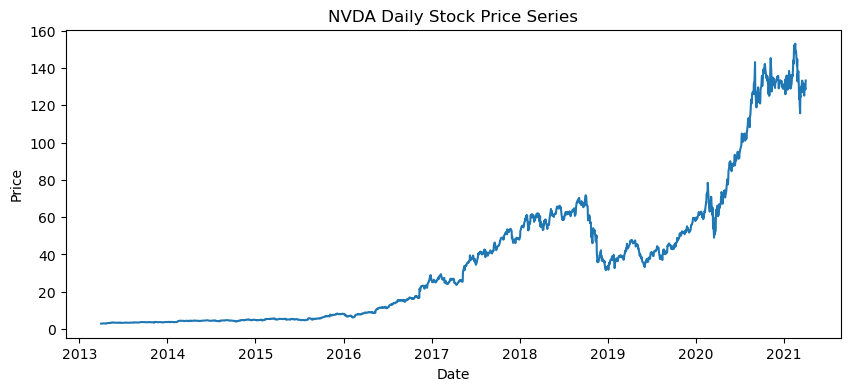

In [8]:
# Plot the price series of NVDA
plt.figure(figsize=(10, 4))
plt.plot(df_daily_prices.index, df_daily_prices)
plt.title("NVDA Daily Stock Price Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

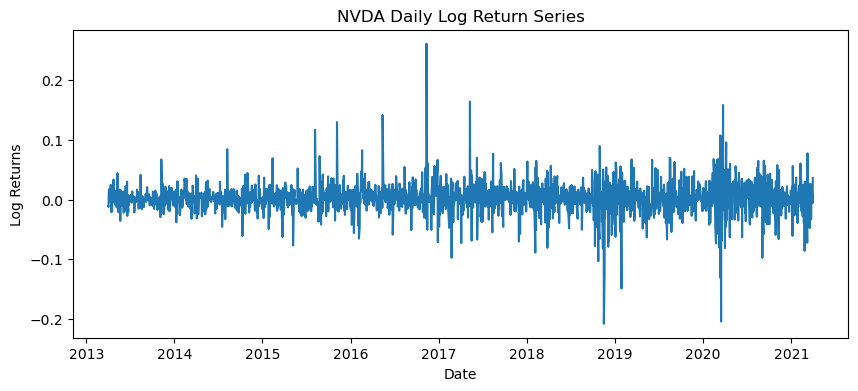

In [9]:
# Plot the log returns of NVDA
plt.figure(figsize=(10, 4))
plt.plot(df_daily_log_returns.index, df_daily_log_returns)
plt.title("NVDA Daily Log Return Series")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.show()

## ACF and PACF

c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


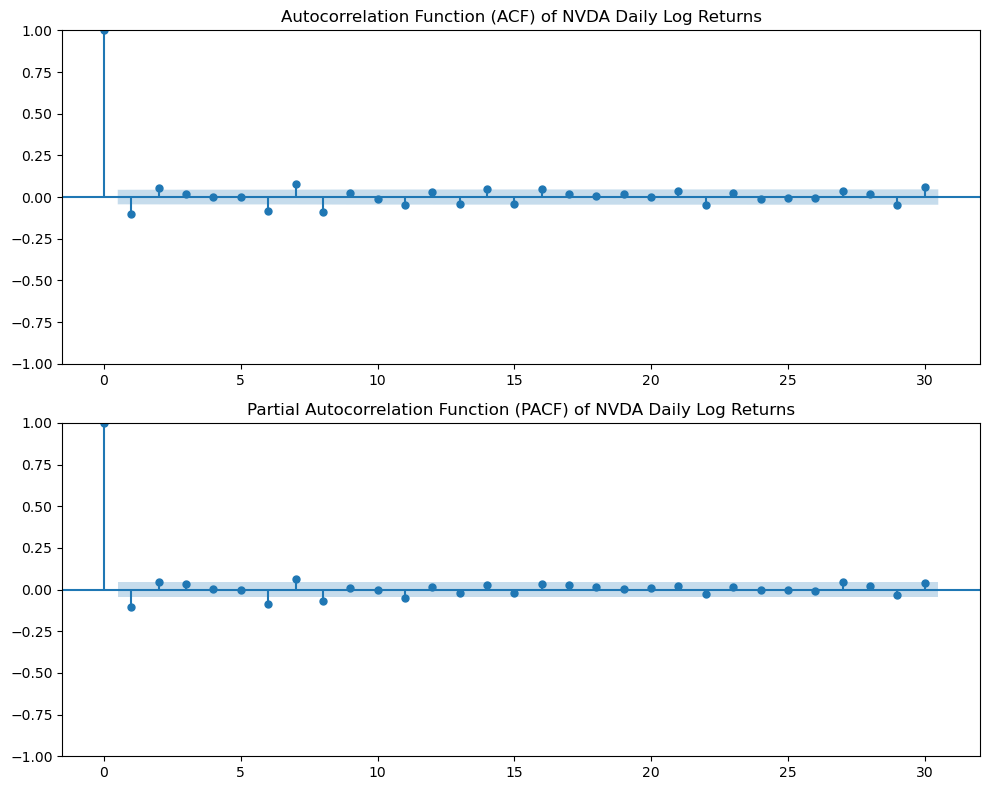

In [10]:
# Plot the ACF and PACF of NVDA log returns
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# ACF plot
plot_acf(df_daily_log_returns, ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) of NVDA Daily Log Returns")

# PACF plot
plot_pacf(df_daily_log_returns, ax=ax[1], lags=30)
ax[1].set_title("Partial Autocorrelation Function (PACF) of NVDA Daily Log Returns")

plt.tight_layout()
plt.show()

## LSTM Model Construction

### Prepare the data

In [11]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_daily_log_returns.values.reshape(-1,1))

# Choose a sequence length for the LSTM
sequence_length = 30  # this is a hyperparameter that you could tune

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size-sequence_length:, :]

# create the training data
x_train = []
y_train = []
for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# create the testing data
x_test = []
y_test = []
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Build LSTM Model

In [12]:
def build_model(hp):
    model = Sequential()
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(LSTM(units=hp.Int('units_' + str(i),
                                    min_value=32,
                                    max_value=512,
                                    step=32),
                       return_sequences=True if i < hp.Int('num_layers', 1, 5) - 1 else False, 
                       input_shape=(x_train.shape[1], 1)))
        model.add(Dropout(hp.Float('dropout_' + str(i),
                                   min_value=0.0,
                                   max_value=0.5,
                                   step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units',
                                 min_value=32,
                                 max_value=512,
                                 step=32)))
    model.add(Dense(units=1))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='models',
    project_name='lstm_optimisation')

tuner.search_space_summary()

tuner.search(x_train, y_train,
             epochs=10,
             validation_data=(x_test, y_test))

tuner.results_summary()

INFO:tensorflow:Reloading Tuner from models\lstm_optimisation\tuner0.json
Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_val

### Save / load model

In [13]:
best_models = tuner.get_best_models(num_models=1) # get the best model(s)
best_model = best_models[0] # if we asked for more than 1 model, choose the first one

best_model.save('models/model.h5') # save the model to a file

In [14]:
# Loading the model
model = load_model('models/model.h5')

### Predict, Convert and Plot

13/13 [==============================] - 2s 6ms/step


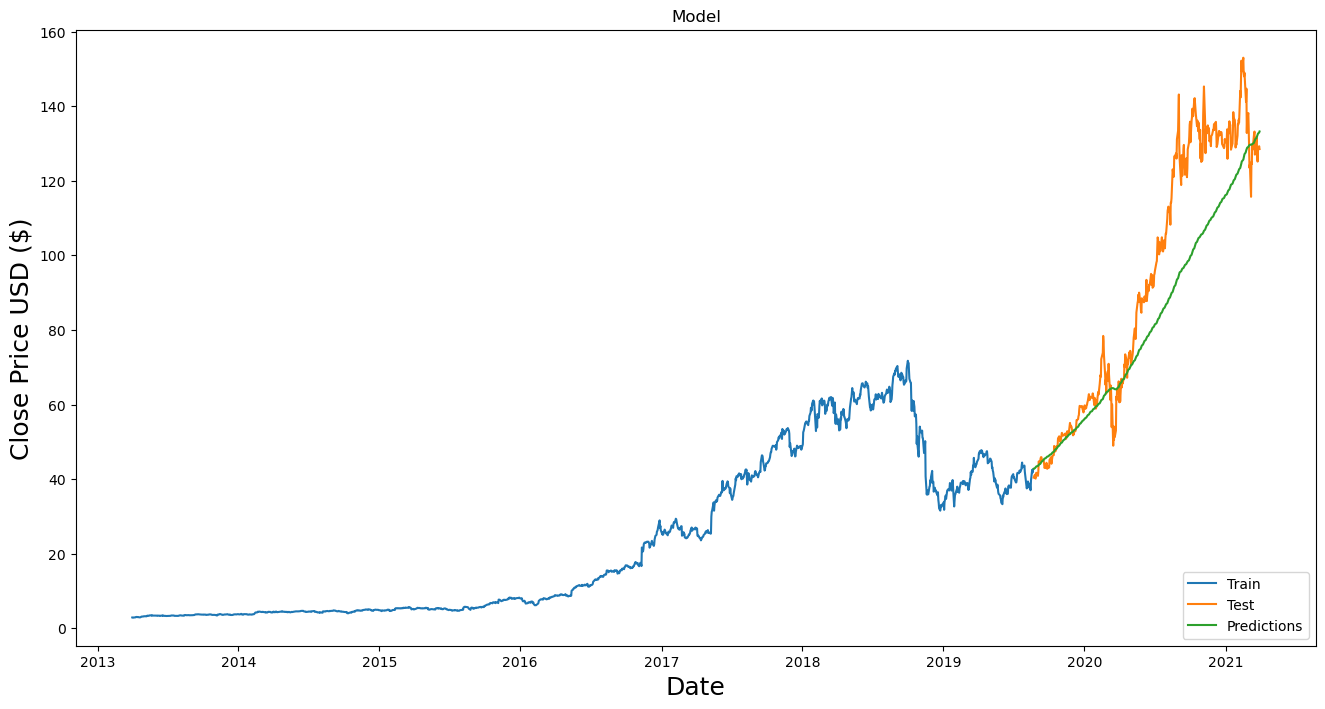

In [15]:
# Predict the log returns
predicted_log_returns = model.predict(x_test)
predicted_log_returns = scaler.inverse_transform(predicted_log_returns)

# Convert the predicted log returns to prices
predicted_prices = np.empty_like(predicted_log_returns)
predicted_prices[0] = df_daily_prices.iloc[train_size-1] * np.exp(predicted_log_returns[0])

for i in range(1, predicted_prices.shape[0]):
    predicted_prices[i] = predicted_prices[i-1] * np.exp(predicted_log_returns[i])

# Correct the index for the predicted prices
start_index = train_size
end_index = start_index + len(predicted_prices)
predicted_prices_df = pd.DataFrame(predicted_prices, index=df_daily_prices.index[start_index:end_index], columns=['Predictions'])

# Plot the results
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_daily_prices[:start_index], label='Train')
plt.plot(df_daily_prices[start_index:end_index], label='Test')
plt.plot(predicted_prices_df['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()




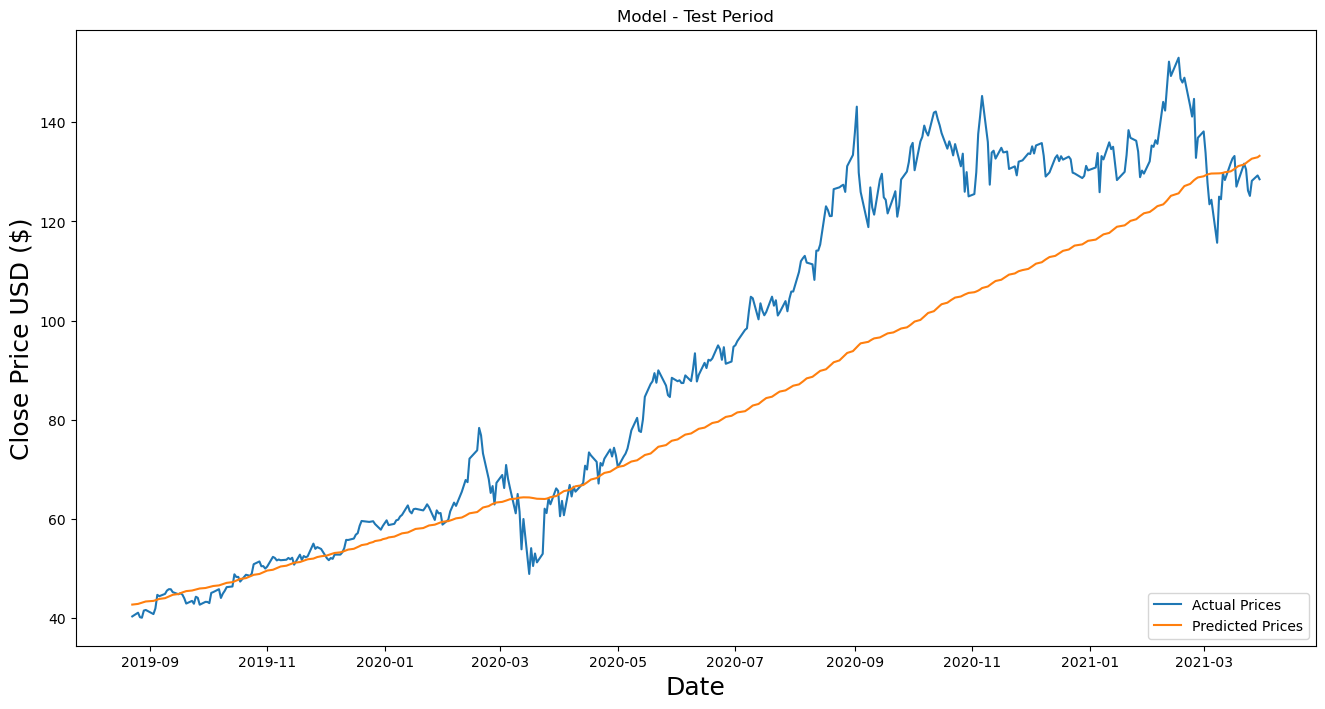

In [16]:
# Plot the results for the test period
plt.figure(figsize=(16,8))
plt.title('Model - Test Period')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_daily_prices[start_index:end_index], label='Actual Prices')
plt.plot(predicted_prices_df['Predictions'], label='Predicted Prices')
plt.legend(loc='lower right')
plt.show()
